In [1]:
import pandas, keras
import numpy as np
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks
import os 
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 5.0)

Using TensorFlow backend.


## Using the right amount of resources

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
set_session(tf.Session(config=config))

# Exploring the dataset:

## Load the dataset files

In [3]:
particles_per_event=20
n_events=10000
features=4

#Load the dataset from storage
store_train = pandas.HDFStore("/disk/lhcb_data/davide/ML4HEP_exercise/train.h5")
df_train = store_train.select("table",stop=n_events)

#Define a list with the desired kinematic variables to access the dataset
cols = [c.format(i) for i in range(particles_per_event) for c in ["E_{0}",  "PX_{0}",  "PY_{0}",  "PZ_{0}"]]

#Extract the train set and the training labels
T = df_train[cols].values[0:n_events].reshape(n_events,particles_per_event,features)
T_labels=df_train["is_signal_new"]

## The dataset tensor
Our dataset is organized in a rank 3 tensor T, whose elements are labeled by indices (i, j, k). Index i runs on the event number, j numbers the particles in each event and index k numbers the variable associated to the track in the event

$$
T = (i=1,...,n_{events}, j=1,...,\textit{particles per event}, k= E_{j} , PX_{j}, PY_{j}, PZ_{j})
$$


In [4]:
T.shape

(10000, 20, 4)

## Fancy indexing

For example, we can access to the single particles four momentum in an event by making use of indexing. Let's take the first particle in the first event: 

In [5]:
print('The first particle in the first event has the following four momentum \n')
print('E_0 = {0:.5g}'.format(T[0,0,0]))
print('PX_0 = {0:.5g}'.format(T[0,0,1]))
print('PY_0 = {0:.5g}'.format(T[0,0,2]))
print('PZ_0 = {0:.5g}'.format(T[0,0,3]))

The first particle in the first event has the following four momentum 

E_0 = 474.07
PX_0 = -250.35
PY_0 = -223.65
PZ_0 = -334.74


The same information can be accessed using numpy fancy indexing syntax, for example

In [6]:
print('The first particle in the first event has the following four momentum \n')
print(T[0,0,:])

The first particle in the first event has the following four momentum 

[ 474.07114 -250.34703 -223.65196 -334.7381 ]


**Exercise**:Now, using numpy array methods calculate:

1) the mean energy of all particles over all events (hint: exclude from the mean the empty events)


2) the mean energy of the first 5 particles for the first 10 events

3) the maximum PZ (in modulus) of the dataset

In [7]:
#Solution:

#1) T[:,:,0][np.where(T[:,:,0]!=0)].mean()
#2) T[0:10,0:5,0].mean()
#3) np.abs(T[:,:,3]).max()

# Variables at hadron colliders: kinematic invariants


The dataset can be cast to the $(E \text{, } \phi \text{, } \eta)$ space.
The rapidity $\eta$ is related to $PZ$ of the particle track. It is defined as:

$$
\eta = \frac{1}{2} ln \left(\frac{E - PZ}{ E + PZ} \right)
$$

While $\phi$ is related to the $(PX, PY)$ components by:

$$
\phi = arctg\left( \frac{PY}{PX} \right)
$$

As shown in figure, the CMS detector is formed by:

1) a cylindrical barrel detector placed around the interaction point that covers a rapidity range of $|\eta| < 2.5 $

2) two $1.48 < | \eta | < 3.0$ endcap regions

<tr>
<td><img src="imgs/front.png" style="width:500px;height:400px;">
<td><img src="imgs/side.png" style="width:500px;height:400px;">
<tr>


<caption><u><font color='purple'>**Figure**</u><font color='purple'>Need a caption here<br> <font color='black'>

## Plotting events

Each event can be displayed as 2D image in the ($\phi, \eta$) coordinates, whose pixels values are the corresponding E recorded by the calorimeter.

First can convert the dataset to this new set of variables. We can do it with a few lines of code thanks to indexing:

In [8]:
eta=np.where(T[:,:,0]==0, 0, 0.5*np.log((T[:,:,0]-T[:,:,3])/(T[:,:,0]+T[:,:,3])));
phi=np.where(T[:,:,0]==0, 0, np.arctan(T[:,:,2]/T[:,:,1]));
E=T[:,:,0];

Then we can check that the $\phi$ angular coverage is of $\pi$

In [9]:
phi_range=np.abs(phi.min())+phi.max()
print(phi_range)

3.1415343


And that the rapidity range is within the expected one

In [10]:
eta_range=np.abs(eta.min())+eta.max()
eta.min(), eta.max()

(-2.7342699, 2.7103007)

In order to draw each event we rescale the dataset to be compatible with the image representation

In [11]:
phi_pixels=eta_pixels=40
eta_rescaled=(eta+np.abs(eta.min()))/eta_range*eta_pixels
phi_rescaled=(phi+np.abs(phi.min()))/phi_range*phi_pixels


pic = np.zeros(shape=(phi_pixels,eta_pixels,1),dtype=np.float32)
pics=np.array([pic for j in range(0,n_events)])
    
for event in range(n_events):

    for n_track in range((phi[event]>0).sum()):
        #print(n_track)
        phi_coord = int(np.floor(phi_rescaled[event][n_track]))-1
        eta_coord = int(np.floor(eta_rescaled[event][n_track]))-1
            
        pics[event,phi_coord,eta_coord]=E[event][n_track]

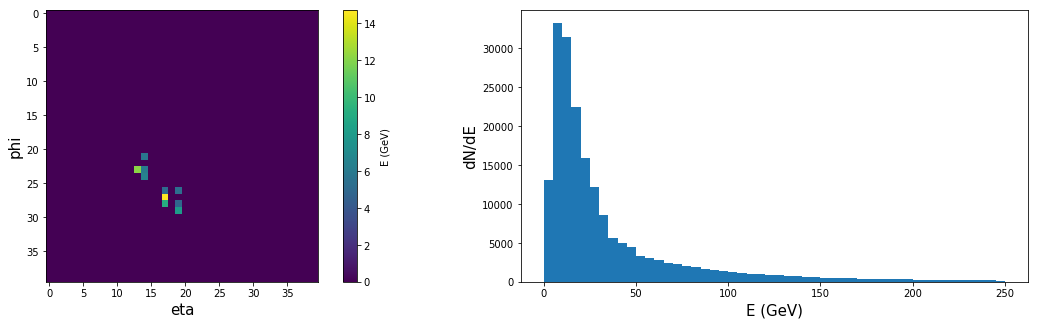

In [12]:
event_display=100
plt.subplot(1,2,1)
plt.imshow(pics[event_display].reshape(40,40))
plt.xlabel('eta', fontsize=15)
plt.ylabel('phi', fontsize=15)
cbar = plt.colorbar()
cbar.set_label('E (GeV)')
plt.subplot(1,2,2)
plt.hist(E[np.where(2<E)],range=(0,250), bins=50);
plt.xlabel('E (GeV)', fontsize=15)
plt.ylabel('dN/dE', fontsize=15)
fig=plt.gcf()
fig.set_size_inches(20,5)

# Building a dense Deep Neural Network

## Adding more layers

Visualising the dataset with images helps to familiarize with the dataset, but in the following example we will treat each image as a flattened vector. Networks dealing with rank 1 inputs are called dense networks. We provide you with the syntax that builds a simple feed forward dense Artificial Neural Network, you should make it deep and add 5 layers of 200 nodes each. The syntax for adding one intermediate layer in keras is the following:

```python
model.add(keras.layers.Dense(output_shape, activation_function)
```

(The keras documentation site is a useful resource if you're stuck at any time: https://keras.io/)

***Exercise***
Add 5 layers, each one containing 200 nodes, using keras syntax


In [16]:
"""
Syntax that creates the network

"""
#Creates the sequential model
model = keras.models.Sequential() 

#First layer of the network
model.add(keras.layers.Dense(2, input_shape = (particles_per_event*features,), activation='softmax'))

####

#Add layers here

####


"""
Syntax that trains the network

"""
model.compile(loss='categorical_crossentropy', \
              optimizer="Adam", \
              metrics = ["accuracy"]) 


model_history = model.fit(x=T.reshape(n_events,particles_per_event*features), \
                          y=keras.utils.to_categorical(T_labels), \
                          validation_split = 0.1, \
                          batch_size=128, \
                          verbose=1, \
                          epochs=50)



The model.fit() method outputs a history object whose keys are

In [17]:
print(model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])



***Exercise***:
Using the train-validation splitting of the train set, show the over-fitting effect of a high capacity network

In [129]:
#Solution
#model.add(keras.layers.Dense(200, input_shape = (particles_per_event*features,), activation='relu'))
#model.add(keras.layers.Dense(200, activation='relu'))
#model.add(keras.layers.Dense(200, activation='relu'))
#model.add(keras.layers.Dense(200, activation='relu'))
#model.add(keras.layers.Dense(200, activation='relu'))
#model.add(keras.layers.Dense(2, activation='softmax'))

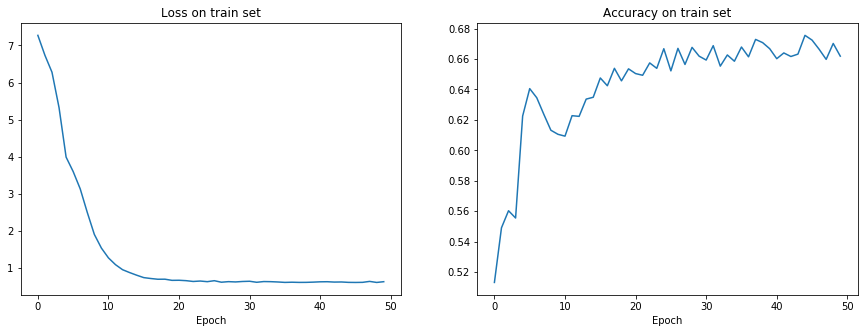

In [14]:
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set')
plt.subplot(1,2,2)
plt.plot(model_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set')
fig = plt.gcf()
fig.set_size_inches(15,5)

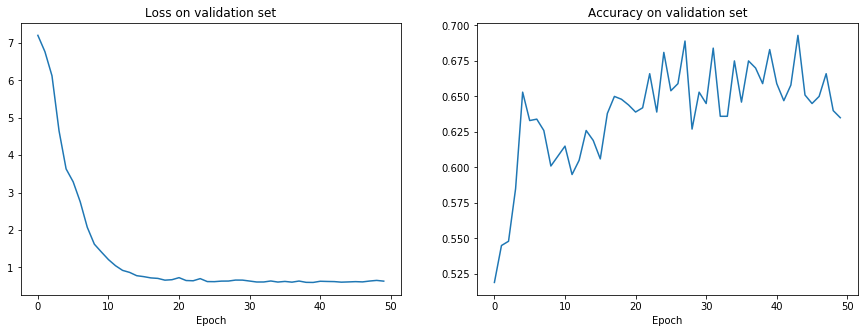

In [15]:
plt.subplot(1,2,1)
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epoch')
plt.title('Loss on validation set')
plt.subplot(1,2,2)
plt.plot(model_history.history['val_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on validation set')
fig = plt.gcf()
fig.set_size_inches(15,5)

# Neural network optimization methods

In order to prevent the overfitting tendency of a high capacity network several regularization methods are available

## 1) L2 regularization


L2 regularization adds a penalty term for the loss which is proportional to the weights' values (L1) or weights' values squared (L2). This prevents some weights to become numerically dominant with respect to others. It consists of appropriately modifying your cost function, from:

$$
\mathcal{L} = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  \hat{y}^{(i)}\log\left(y^{(i)}\right) + (1-\hat{y}^{(i)})\log\left(1- y^{(i)}\right) \large{)} 
$$
To:
$$\mathcal{L}_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small \hat{y}^{(i)}\log\left(y^{(i)}\right) + (1-\hat{y}^{(i)})\log\left(1- y^{(i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

where $\hat{y}^{(i)}$, ($y^{(i)}$) is the label (network prediction) of the $i$-ith example, $m$ is the total number of examples in the train set and $\lambda$ is the regularization weight. The index $l$ runs on the layer numbers and $W_{k}{j}$ are the weight matrices of the network.

In keras, the regularization term are applied on a per-layer basis through the keyword argument

```python
model.add(keras.layers.Dense(output_shape, kernel_regularizer.l2(0.01), activation_function)
```

***Exercise***
Show the effect of adding L2 regularization on the loss function and on the train/validation accuracies, you can play with the hyperparameter $\lambda$ (called ```lambd``` in code) and see the effect of stronger regularization

In [30]:
from keras import regularizers
"""
Syntax that creates the network

"""
#Creates the sequential model

model_with_reg = keras.models.Sequential() 
lambd=0.01

##################


#Add layers with l2 regularization here


#################

"""
Syntax that trains the network

"""
model_with_reg.compile(loss='categorical_crossentropy', \
              optimizer="Adam", \
              metrics = ["accuracy"]) 


model_with_reg_history = model_with_reg.fit(x=T.reshape(n_events,particles_per_event*features), \
                                            y=keras.utils.to_categorical(T_labels), \
                                            validation_split = 0.1, \
                                            batch_size=128, \
                                            verbose=1, \
                                            epochs=50)



ValueError: Error when checking target: expected sequential_10_input to have shape (80,) but got array with shape (2,)

In [ ]:
#Solution
#model_with_reg.add(keras.layers.Dense(200, input_shape = (particles_per_event*features,), activation='relu'))
#model_with_reg.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd), activation='relu'))
#model_with_reg.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd), activation='relu'))
#model_with_reg.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd), activation='relu'))
#model_with_reg.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd), activation='relu'))
#model_with_reg.add(keras.layers.Dense(2, activation='softmax'))

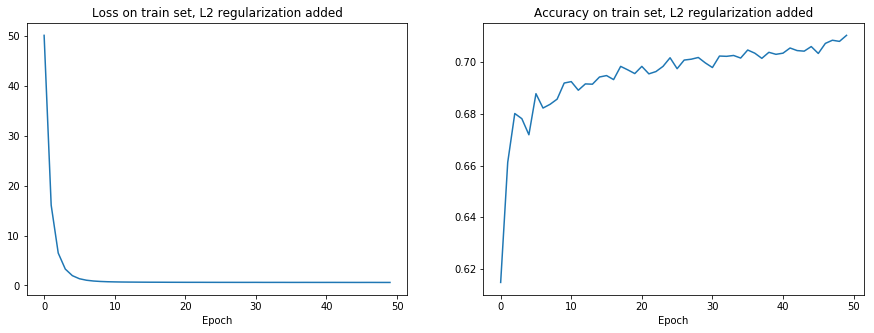

In [28]:
plt.subplot(1,2,1)
plt.plot(model_with_reg_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, L2 regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_reg_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, L2 regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

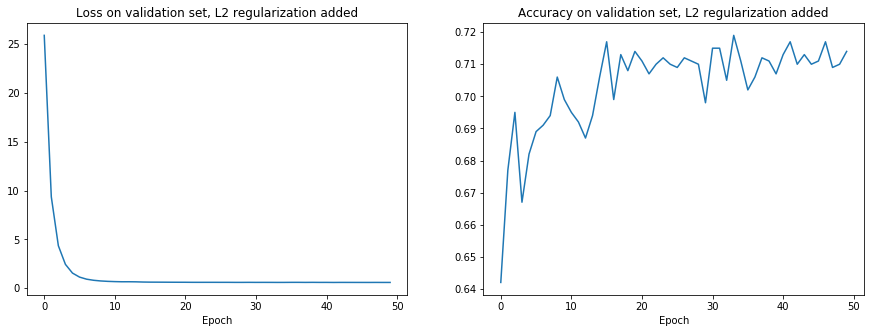

In [29]:
plt.subplot(1,2,1)
plt.plot(model_with_reg_history.history['val_loss'])
plt.xlabel('Epoch')
plt.title('Loss on validation set, L2 regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_reg_history.history['val_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on validation set, L2 regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

## 2) Dropout regularization

Dropout regularization acts during training, it introduces a non-zero probability of switching some weights' values to zero. By doing this, the network is taught not to rely to heavily on one particular weight and helps preventing overfitting

***Exercise*** Test dropout regularization on the same network and draw the loss/accuracy plots, play with the ```dropout_rate``` and vary the average fraction of input units set to $0$ during training

In [31]:
from keras import regularizers
"""
Syntax that creates the network

"""
#Creates the sequential model
model_with_drop = keras.models.Sequential() 
dropout_rate=0.1

##################


#Place layers with dropout regularization here


#################

"""
Syntax that trains the network

"""
model_with_drop.compile(loss='categorical_crossentropy', \
              optimizer="Adam", \
              metrics = ["accuracy"]) 


model_with_drop_history = model_with_drop.fit(x=T.reshape(n_events,particles_per_event*features), \
                                            y=keras.utils.to_categorical(T_labels), \
                                            validation_split = 0.1, \
                                            batch_size=128, \
                                            verbose=1, \
                                            epochs=50)



Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 1s 133us/step - loss: 1.4335 - acc: 0.5664 - val_loss: 0.6251 - val_acc: 0.6520
Epoch 2/50
9000/9000 [==============================] - 0s 34us/step - loss: 0.6993 - acc: 0.6110 - val_loss: 0.6023 - val_acc: 0.6680
Epoch 3/50
9000/9000 [==============================] - 0s 32us/step - loss: 0.6496 - acc: 0.6326 - val_loss: 0.5976 - val_acc: 0.6790
Epoch 4/50
9000/9000 [==============================] - 0s 33us/step - loss: 0.6252 - acc: 0.6523 - val_loss: 0.5833 - val_acc: 0.6860
Epoch 5/50
9000/9000 [==============================] - 0s 33us/step - loss: 0.6178 - acc: 0.6610 - val_loss: 0.5812 - val_acc: 0.6850
Epoch 6/50
9000/9000 [==============================] - 0s 32us/step - loss: 0.6080 - acc: 0.6692 - val_loss: 0.5737 - val_acc: 0.7010
Epoch 7/50
9000/9000 [==============================] - 0s 32us/step - loss: 0.5952 - acc: 0.6759 - val_loss: 0.5740 - val_acc: 0.7080
Epoch 

In [ ]:
#Solution
#model_with_drop.add(keras.layers.Dense(200, input_shape = (particles_per_event*features,), activation='relu'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate, ))
#model_with_drop.add(keras.layers.Dense(200, activation='relu'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate, ))
#model_with_drop.add(keras.layers.Dense(200, activation='relu'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate, ))
#model_with_drop.add(keras.layers.Dense(200, activation='relu'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate, ))
#model_with_drop.add(keras.layers.Dense(200, activation='relu'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate, ))
#model_with_drop.add(keras.layers.Dense(2, activation='softmax'))

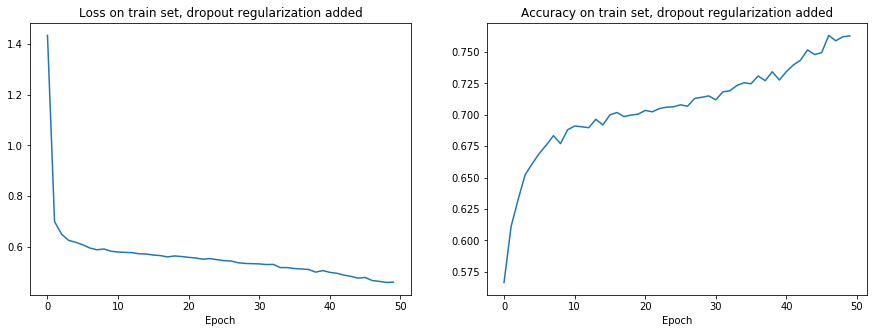

In [32]:
plt.subplot(1,2,1)
plt.plot(model_with_drop_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, dropout regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_drop_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, dropout regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

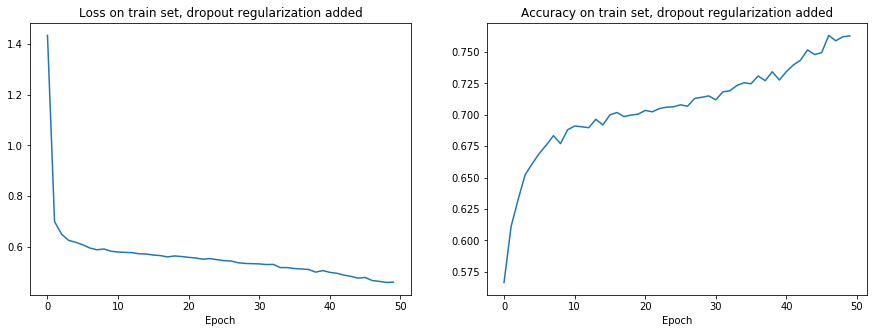

In [33]:
plt.subplot(1,2,1)
plt.plot(model_with_drop_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, dropout regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_drop_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, dropout regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

## 3) Adding batch-normalization

In [4]:
### Evaluate performance on independent sample
# DO NOT CHANGE BELOW!

# Prepare input
store_test = pandas.HDFStore("test_without_truth_100k.h5")
df_test = store_test.select("table")

# Run DNN
print("Running on full test sample. This may take a moment.")
ret = model.predict(df_test[cols].as_matrix())
np.save("result.npy",ret[:,1])
!zip result.zip result.npy
print("Done. Click below  to download result")
FileLink('result.zip')

Running on full test sample. This may take a moment.
updating: result.npy (deflated 10%)
Done. Click below  to download result


/home/ubuntu/challenge/result.zip